# Regressão, Sobre-Ajuste e Adequação de Modelos

As redes neurais multi-camadas possuem capacidade de aproximação universal. Porém, como vimos, nem sempre é trivial encontrar a configuração de pesos coneccionistas que melhor modela - e extrapola - um determinado conjunto de dados. Essa dificuldade pode ser decorrente da *falta de informação nas descrições vetoriais dos dados*, mas também pode se dever ao *excesso de parâmetros da rede*. Esses dois conceitos devem estar claros para o estudante que deseja seguir adiante, então recomendo que algum tempo seja reservado para fazer dois desenhos, cada um explicando uma dessas dificuldades.

Além disso, antes de prosseguir com esta interação, o estudante deve estar familiarizado preparado para discutir:

1. As diferenças entre sistemas de aprendizado paramétricos e sistemas não-paramétricos,
2. Como funciona o aprendizado por gradiente descendente e retropropagação de erro em redes MLP.

Vamos tomar por base o código de retropropagação de erro construído na interação anterior:

In [78]:
# Inicializacao
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

def nova_mlp(entradas, saidas, camadas):
    lista_de_camadas = [entradas] + camadas + [saidas]
    pesos = []
    for i in xrange(len(lista_de_camadas)-1):
        pesos.append(np.random.random((lista_de_camadas[i+1], lista_de_camadas[i])))
    return pesos

def ff_mlp(entradas, pesos):
    s = entradas
    for i in xrange(len(pesos)-1):
        s = np.tanh(np.dot(pesos[i],s))
    s = np.dot(pesos[-1],s)
    return s

def backpropagation_step(entradas, saidas, pesos, passo=0.01):
    derivadas = []
    resultados_intermediarios = [entradas]
    s = entradas
    for i in xrange(len(pesos)-1):
        s = np.tanh(np.dot(pesos[i],s))
        resultados_intermediarios.append(s)
    s = np.dot(pesos[-1],s)
    resultados_intermediarios.append(s)
  
    # Derivada do erro em relacao a saida estimada
    dedye = (resultados_intermediarios[-1] - saidas)
    
    # Derivada em relacao a camada de saida linear
    dedb = np.dot(dedye, resultados_intermediarios[-2].T)
    
    # Para cada camada nao-linear, calcula a nova derivada na forma:
    deda = dedye

    for i in range(len(pesos)-2, -1, -1):
        linear = np.dot(pesos[i], resultados_intermediarios[i])
        flz = (1-np.tanh(linear)**2) 
        deda = np.dot(pesos[i+1].T, deda) # deriv_front
        derivada = np.dot(deda * flz, resultados_intermediarios[i].T)
        derivadas.insert (0, derivada)

    derivadas.append(dedb)
    
    # Executa um passo na direcao contraria da derivada
    for i in xrange(len(derivadas)):
        n = np.linalg.norm(derivadas[i])
        pesos[i] -= passo * derivadas[i]/n
    
    return pesos

def erro(y, y_e):
    return np.sum((y-y_e)**2)

## Regressão

A regressão é a tarefa de encontrar um modelo para a função que leva dados de entrada a dados de saída. O modelo, idealmente, deve ser útil para a aplicação em questão - comumente, realizar predições sobre o novos dados que poderiam ser gerados pelo mesmo processo.

## Sobre-ajuste e modelos inadequados

Sobre-ajuste é um fenômeno que ocorre quando um sistema é muito ajustado para um determinado conjunto de entrada e, assim, perde capacidade de generalização. Esse fenômeno é observável e, também, é previsto em teoria. Trata-se do *no free lunch theorem*, que mostra que quando um sistema se torna mais especializado numa tarefa, ele se tornará menos especializado em todas as outras tarefas. Assim, o procedimento de treino por gradiente descendente só é eficaz na medida que os dados de treinamento são representantes eficazes para os dados de teste.

Esse fenômeno fica bastante visível em problemas de regressão. A seguir, usarei uma rede neural para aproximar uma parábola:

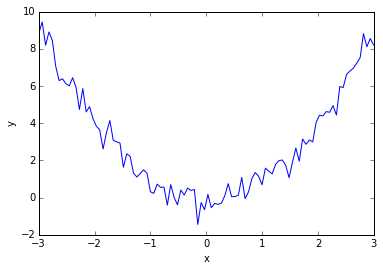

In [104]:
x = np.linspace(-3, 3, num=100)
y_ = x**2
y = y_ + np.random.normal(0, 0.5, 100) # Criando uma parabola com ruido
plt.figure();
plt.plot(x, y);
plt.ylabel('y');
plt.xlabel('x');

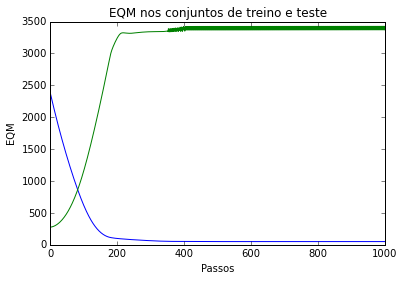

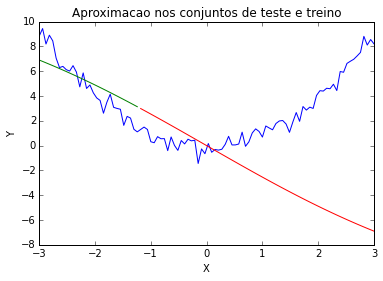

In [105]:
# Caso 1: usando as 30 primeiras amostras (30% do total) para o aprendizado
x.shape = (1, x.size)
y.shape = (1, y.size)
x_treino = x[:,0:30]
x_teste = x[:,30:100]
y_treino = y[:,0:30]
y_teste = y[:,30:100]

mlp0 = nova_mlp(entradas=1, saidas=1, camadas=[13])

# Processo de treinamento
n_passos = 1000
eqm_treino = np.zeros((n_passos+1))
eqm_treino[0] = erro(y_treino, ff_mlp(x_treino, mlp0))
eqm_teste = np.zeros((n_passos+1))
eqm_teste[0] = erro(y_teste, ff_mlp(x_teste, mlp0))

for i in xrange(n_passos):
    mlp0 = backpropagation_step(x_treino, y_treino, mlp0)
    eqm_treino[i+1] = erro(y_treino, ff_mlp(x_treino, mlp0))
    eqm_teste[i+1] = erro(y_teste, ff_mlp(x_teste, mlp0))
    
plt.figure();
plt.plot(range(n_passos+1), eqm_treino);
plt.plot(range(n_passos+1), eqm_teste);
plt.ylabel('EQM');
plt.xlabel('Passos');
plt.title('EQM nos conjuntos de treino e teste');

plt.figure();
plt.plot(x.T, y.T);
plt.plot(x_treino.T, ff_mlp(x_treino, mlp0).T);
plt.plot(x_teste.T, ff_mlp(x_teste, mlp0).T);
plt.ylabel('Y');
plt.xlabel('X');
plt.title('Aproximacao nos conjuntos de teste e treino');


Este experimento evidencia uma importante característica das redes neurais: elas são incapazes de aprender situações que não lhes foram apresentadas durante a etapa de treinamento. Assim, pode ser uma boa idéia usar, como dados de treinamento, entradas que são distribuídas por todo o domínio da função a ser modelada. Em problemas de classificação, isso significa usar exemplos variados de cada classe. Assim, se utilizarmos o seguinte procedimento:


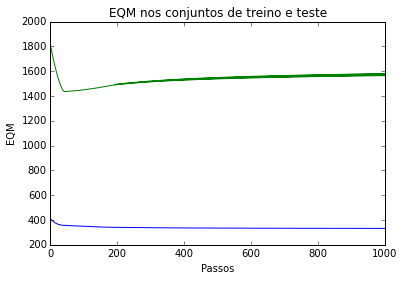

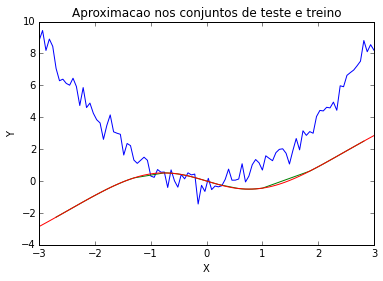

In [106]:
# Caso 2: usando 30 amostras aleatoriamente escolhidas (30% do total) para o aprendizado
import random
x.shape = (x.size)
y.shape = (y.size)

train_array = np.zeros((x.size)).astype(bool)
test_array = np.ones((x.size)).astype(bool)
while np.sum(train_array) < 30:
    n = int(random.random() * x.size)
    test_array[n] = False
    train_array[n] = True

x_treino = x[train_array]
x_teste = x[test_array]
y_treino = y[train_array]
y_teste = y[test_array]

x_treino.shape = (1,x_treino.size)
y_treino.shape = (1,y_treino.size)
x_teste.shape = (1,x_teste.size)
y_teste.shape = (1,y_teste.size)

mlp0 = nova_mlp(entradas=1, saidas=1, camadas=[10])

# Processo de treinamento
n_passos = 1000
eqm_treino = np.zeros((n_passos+1))
eqm_treino[0] = erro(y_treino, ff_mlp(x_treino, mlp0))
eqm_teste = np.zeros((n_passos+1))
eqm_teste[0] = erro(y_teste, ff_mlp(x_teste, mlp0))

for i in xrange(n_passos):
    mlp0 = backpropagation_step(x_treino, y_treino, mlp0)
    eqm_treino[i+1] = erro(y_treino, ff_mlp(x_treino, mlp0))
    eqm_teste[i+1] = erro(y_teste, ff_mlp(x_teste, mlp0))
    
plt.figure();
plt.plot(range(n_passos+1), eqm_treino);
plt.plot(range(n_passos+1), eqm_teste);
plt.ylabel('EQM');
plt.xlabel('Passos');
plt.title('EQM nos conjuntos de treino e teste');

plt.figure();
plt.plot(x.T, y.T);
plt.plot(x_treino.T, ff_mlp(x_treino, mlp0).T);
plt.plot(x_teste.T, ff_mlp(x_teste, mlp0).T);
plt.ylabel('Y');
plt.xlabel('X');
plt.title('Aproximacao nos conjuntos de teste e treino');

Por um lado, a escolha correta dos dados atenuou a disparidade dos comportamentos dos erros de treinamento e teste. Porém, ainda não resolveu o problema de aproximar corretamente a parábola, em especial considerando a presença de ruído. Além disso, nem sempre é simples - ou prático - encontrar dados de treinamento que interpolam todo o comportamento da função que se deseja modelar.

Para resolver esse problema, poderíamos assumir que conhecemos o modelo $x^2$ que gerou a função, e então utilizar um regressor linear:

EQM:  15.9345102829
[[-0.02557653  1.01904079]]


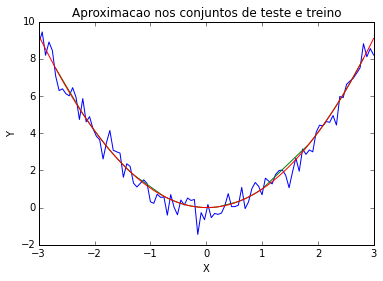

In [107]:
x_treino2 = np.vstack((x_treino, x_treino**2))
x_teste2 = np.vstack((x_teste, x_teste**2))

# Ax = y -> A = y * pinv(x)
A = np.dot(y_treino, np.linalg.pinv(x_treino2))
y_est = np.dot(A, x_teste2)

print "EQM: ", erro(y_teste, y_est)
print A
plt.figure();
plt.plot(x.T, y.T);
plt.plot(x_treino.T, np.dot(A, x_treino2).T);
plt.plot(x_teste.T, np.dot(A, x_teste2).T);
plt.ylabel('Y');
plt.xlabel('X');
plt.title('Aproximacao nos conjuntos de teste e treino');

Podemos verificar, tanto graficamente quanto no cálculo do EQM, que o erro de aproximação é bem menor que no caso da rede MLP. Por outro lado, poderíamos dizer que houve uma certa "trapaça", já que o modelo linear já aproveitou a informação de que $x^2$ é uma variável válida na entrada. Se fizermos o mesmo proceso na rede MLP, teremos:

EQM final: 28.4005410833


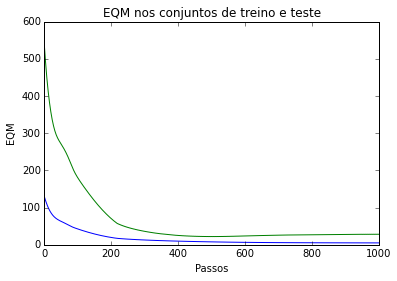

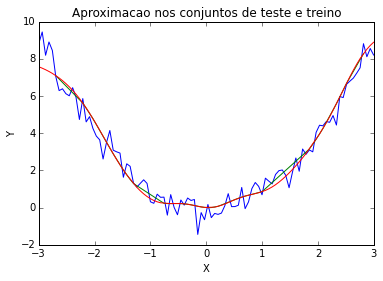

In [116]:
mlp0 = nova_mlp(entradas=2, saidas=1, camadas=[10])

# Processo de treinamento
n_passos = 1000
eqm_treino = np.zeros((n_passos+1))
eqm_treino[0] = erro(y_treino, ff_mlp(x_treino2, mlp0))
eqm_teste = np.zeros((n_passos+1))
eqm_teste[0] = erro(y_teste, ff_mlp(x_teste2, mlp0))

for i in xrange(n_passos):
    mlp0 = backpropagation_step(x_treino2, y_treino, mlp0)
    eqm_treino[i+1] = erro(y_treino, ff_mlp(x_treino2, mlp0))
    eqm_teste[i+1] = erro(y_teste, ff_mlp(x_teste2, mlp0))

print "EQM final:", eqm_teste[-1]
    
plt.figure();
plt.plot(range(n_passos+1), eqm_treino);
plt.plot(range(n_passos+1), eqm_teste);
plt.ylabel('EQM');
plt.xlabel('Passos');
plt.title('EQM nos conjuntos de treino e teste');

plt.figure();
plt.plot(x.T, y.T);
plt.plot(x_treino.T, ff_mlp(x_treino2, mlp0).T);
plt.plot(x_teste.T, ff_mlp(x_teste2, mlp0).T);
plt.ylabel('Y');
plt.xlabel('X');
plt.title('Aproximacao nos conjuntos de teste e treino');

Vemos que nossa rede, agora, tem uma estrutura adequada para executar a regressão sobre os dados de treino. Porém, parece aproximar a parábola com alguma distorção, já que, além da própria parábola, o modelo também tenta aproximar o ruído.

À partir desses exemplos, verificamos algumas diretrizes para o uso de redes neurais. É importante discutir cada uma delas:

1. Redes neurais têm capacidade de aproximação universal, mas isso não significa que é simples encontrar a configuração que fornece essa aproximação,
2. Modelos mais simples podem fornecer respostas melhores e mais rápidas que as redes neurais,
3. Mesmo assim, redes neurais serão capazes de fornecer algum resultado, o que pode ser melhor que não ter resultado nenhum,
4. Etapas de pré-processamento de dados podem ser importantes no processo de predição, gerando novas maneiras de relacionar entradas e saídas que possivelmente serão mais relevantes e/ou passíveis de generalização.

## Modelos mais simples e a extrapolação

Até então, combinamos duas estratégias diferentes: a escolha cuidadosa de pontos de dados e o pré-processamento das entradas (calculando $x^2$). A seguir, verificaremos o comportamento dos dois modelos - linear e MLP - frente a um cenário em que fizemos o pré-processamento dos dados, mas não fomos capazes de buscar amostras uniformemente distribuídas por todo o domínio.

EQM:  14.4628107679
[[-0.06248767  1.00456253]]


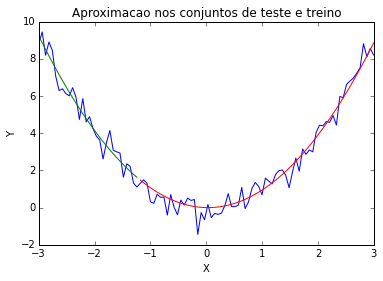

In [117]:
# Usando as 30 primeiras amostras (30% do total) para o aprendizado
x.shape = (1, x.size)
y.shape = (1, y.size)
x_treino = x[:,0:30]
x_teste = x[:,30:100]
y_treino = y[:,0:30]
y_teste = y[:,30:100]

x_treino2 = np.vstack((x_treino, x_treino**2))
x_teste2 = np.vstack((x_teste, x_teste**2))

# Ax = y -> A = y * pinv(x)
A = np.dot(y_treino, np.linalg.pinv(x_treino2))
y_est = np.dot(A, x_teste2)

print "EQM: ", erro(y_teste, y_est)
print A
plt.figure();
plt.plot(x.T, y.T);
plt.plot(x_treino.T, np.dot(A, x_treino2).T);
plt.plot(x_teste.T, np.dot(A, x_teste2).T);
plt.ylabel('Y');
plt.xlabel('X');
plt.title('Aproximacao nos conjuntos de teste e treino');

Como podemos ver, o modelo linear apresentou resultados a aqueles encontrados no caso da amostragem uniforme.

EQM final: 1661.02800151


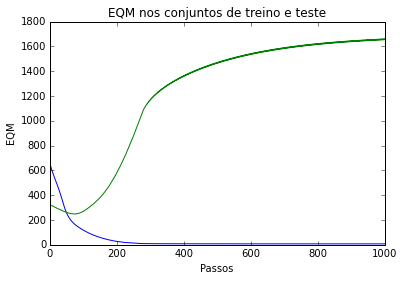

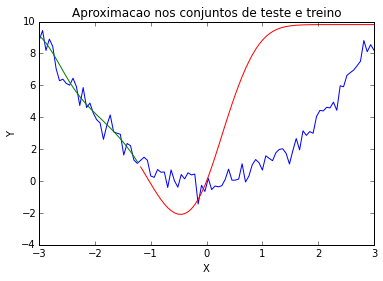

In [122]:
mlp0 = nova_mlp(entradas=2, saidas=1, camadas=[5])

# Processo de treinamento
n_passos = 1000
eqm_treino = np.zeros((n_passos+1))
eqm_treino[0] = erro(y_treino, ff_mlp(x_treino2, mlp0))
eqm_teste = np.zeros((n_passos+1))
eqm_teste[0] = erro(y_teste, ff_mlp(x_teste2, mlp0))

for i in xrange(n_passos):
    mlp0 = backpropagation_step(x_treino2, y_treino, mlp0)
    eqm_treino[i+1] = erro(y_treino, ff_mlp(x_treino2, mlp0))
    eqm_teste[i+1] = erro(y_teste, ff_mlp(x_teste2, mlp0))

print "EQM final:", eqm_teste[-1]
    
plt.figure();
plt.plot(range(n_passos+1), eqm_treino);
plt.plot(range(n_passos+1), eqm_teste);
plt.ylabel('EQM');
plt.xlabel('Passos');
plt.title('EQM nos conjuntos de treino e teste');

plt.figure();
plt.plot(x.T, y.T);
plt.plot(x_treino.T, ff_mlp(x_treino2, mlp0).T);
plt.plot(x_teste.T, ff_mlp(x_teste2, mlp0).T);
plt.ylabel('Y');
plt.xlabel('X');
plt.title('Aproximacao nos conjuntos de teste e treino');

A rede MLP apresentou ganho de desempenho para os dados de treino, mas um comportamento estranho para os dados de teste.

Infelizmente, em aplicações reais, é comum o caso em que a amostragem dos dados de treino e teste não é uniforme.

## Exercício

Tome um problema de regressão, da vida real, à sua escolha. Proponha um procedimento de treino e teste de um modelo, explicitando:
1. A relevância do problema.
2. As dimensões dos vetores de entrada e saída
3. O procedimento (logístico) para obter dados de teste e de treino
4. A necessidade de pré-processar entradas
5. O impacto de uma boa rede neural para este resultado específico.
